In [1]:
import os
from dotenv import load_dotenv

# Load the environment variables
load_dotenv()

# Retrieve API keys
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")

# Check if keys are loaded (optional, remove in production)
print("Pinecone API Key:", PINECONE_API_KEY)

Pinecone API Key: 16db50ea-6d7a-43fe-8c8f-2e78efdd3f98


In [2]:
import transformers
print(transformers.__version__)



c:\Users\1rn17\chatbot\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.46.0


LOAD BASE MODEL

In [3]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1")

Loading checkpoint shards: 100%|██████████| 2/2 [01:10<00:00, 35.33s/it]


In [3]:
import torch

if torch.cuda.is_available():
    print("GPU is available and ready to use:", torch.cuda.get_device_name(0))
else:
    print("GPU not detected; using CPU.")


GPU is available and ready to use: NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
!nvidia-smi


Sat Nov  9 13:15:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P3             11W /   35W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)  # This should show "12.6" or compatible


2.5.1+cu118
True
11.8


In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [6]:
# Clear any cached memory
torch.cuda.empty_cache()

In [9]:
import torch

# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the first available GPU
else:
    device = torch.device("cpu")    # Fallback to CPU

# Convert the model to half-precision (optional)
model = model.half()

# Move the model to the chosen device (GPU or CPU)
model = model.to(device)

print(f"Model is moved to {device}")


Model is moved to cuda


In [10]:
if next(model.parameters()).is_cuda:
    print("The model is on the GPU.")
else:
    print("The model is on the CPU.")

The model is on the GPU.


In [7]:
import cohere
import os
import torch

# Initialize Cohere client
co = cohere.Client(api_key=os.getenv("COHERE_API_KEY"))

In [8]:
import embedding as emb
index = emb.get_index("cohere-pinecone-tree")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\1rn17\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1rn17\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\1rn17\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


BASE MODEL GENERATION - Embed the query and get top k from RAG

In [15]:
def get_top_3_similar(query):
    # Query embedding using Cohere
    embeddings = co.embed(texts=[query], model="embed-english-v3.0", input_type="search_query").embeddings
    # Querying the index for top 3 similar results
    query_results = index.query(vector=embeddings, top_k=3, include_metadata=True)
    return query_results

def generate_response(context, query):
    # Prepare the input prompt for the model
    input_prompt = f"You are a chatbot which generates a response solely based on the context provided. Generate a response that is at least 300 words.\n\nContext: {context}\n\nQuery: {query}\n\nAnswer:"

    # Tokenize the input
    inputs = tokenizer(input_prompt, return_tensors="pt").to(device)

    # Generate response using Mistral 7B
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=2000, num_return_sequences=1, temperature=0.5)

    # Decode the generated text
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract the answer from the response
    answer_start = response.find("Answer:") + len("Answer:")
    return response[answer_start:].strip()

# Example usage
query = 'Hi, Sanjay. Explain the diagnosis of Atrial Septal Defect?'
result = get_top_3_similar(query)

# Forming the context from results
context = " ".join([match['metadata']['text'] for match in result['matches']])
print("Prepared Context for Mistral 7B:", context)

# Generating answer using Mistral 7B
answer = generate_response(context, query)
print("Conversational Answer:", answer)

Prepared Context for Mistral 7B: malformations a vms arteritis giant cell temporal takayasu’s arthritis gonococcal with inﬂammatory bowel disease juvenile rheumatoid nongonococcal acute bacterial osteoarthritis psoriatic reactive rheumatoid septic articular disease see arthritis speciﬁc types asbestosis ascariasis ascaris lumbricoides ascites aspergillosis allergic bronchopulmonary aspiration foreign body aspirin poisoning asthma astrocytoma asymptomatic bacteriuria atopic dermatitis atopic eczema atpb gene mutation atrial ﬁbrillation atrial ﬂutter atrial myxoma atrial septal defect atrial tachycardia multifocal atrioventricular block atropine as antidote poisoning with attentiondeﬁcithyperactivity disorder adhd atypical antidepressant poisoning atypical glandular cells of undetermined signiﬁcanceagus agc atypical pneumonia atypical squamous cells of undetermined signiﬁcanceascus asc austin flint murmur autoimmune disorders see rheumatologic andautoimmune disordersspeciﬁc disorders aut

c:\Users\1rn17\chatbot\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Conversational Answer: Atrial septal defect (ASD) is a congenital heart defect that occurs when there is an opening in the wall between the two upper chambers of the heart (atria). This opening allows oxygen-rich blood to flow from the left atrium to the right atrium, which can lead to heart failure and other complications.

The diagnosis of ASD is typically made through a combination of physical examination, medical history, and diagnostic tests. During a physical examination, the doctor may listen to the heart and lungs for abnormal sounds or murmurs, which can indicate the presence of an ASD. The doctor may also check for signs of heart failure, such as swelling in the legs or abdomen.

Medical history is also important in the diagnosis of ASD. The doctor may ask about any symptoms the patient is experiencing, such as shortness of breath, fatigue, or palpitations. The doctor may also ask about any family history of heart defects or other medical conditions that could be related to A

In [11]:
# Set the pad token to the eos token if padding is missing
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


BASE MODEL EVALUATION - QUERY SET 1

In [16]:
import json
import spacy
import torch
import nltk
from nltk.translate.bleu_score import sentence_bleu
from bert_score import BERTScorer
import time


# Download NLTK data for BLEU
nltk.download('punkt')

# Load a spaCy model for linguistic analysis
nlp = spacy.load("en_core_web_sm")

# Load BERT scorer
bert_scorer = BERTScorer(lang='en', rescale_with_baseline=True)

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def evaluate_model(response, expected):
    results = {
        'accuracy': response.strip() == expected.strip(),
        'fluency': None,
        'coherence': None,
        'bleu_score': None,
        'bert_score': None,
        'perplexity': None
    }

    # Check fluency
    doc = nlp(response)
    sentence_spans = list(doc.sents)
    results['fluency'] = sum([1 for sent in sentence_spans if sent.text.strip()]) / len(sentence_spans)

    # Check coherence
    context_words = expected.split() if expected else []
    response_words = response.split()

    if context_words:
        common_words = set(context_words).intersection(set(response_words))
        coherence_score = len(common_words) / len(context_words) if len(context_words) > 0 else 0
        results['coherence'] = coherence_score
    else:
        results['coherence'] = 0.5

    # Adjust accuracy based on coherence score
    if results['coherence'] >= 0.4:
        results['accuracy'] = True

    # Calculate BLEU score
    reference = [expected.split()]  # BLEU requires references to be a list of lists
    candidate = response.split()
    results['bleu_score'] = sentence_bleu(reference, candidate)

    # Calculate BERT score
    P, R, F1 = bert_scorer.score([response], [expected])
    results['bert_score'] = F1.mean().item()

    # Calculate Perplexity with consistent batch sizing
    inputs = tokenizer(response, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    labels = tokenizer(expected, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    
    # Make sure inputs and labels are of the same shape
    if inputs.shape != labels.shape:
        # Adjust sizes by padding to match the longest sequence
        max_length = max(inputs.shape[1], labels.shape[1])
        inputs = torch.nn.functional.pad(inputs, (0, max_length - inputs.shape[1]), value=tokenizer.pad_token_id)
        labels = torch.nn.functional.pad(labels, (0, max_length - labels.shape[1]), value=-100)  # Ignore padding in labels for loss calculation

    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        results['perplexity'] = torch.exp(loss).item()

    return results

def load_evaluation_data():
    # Dummy implementation for loading expected responses
    return {
        'Hi, Sanjay. What else can you tell about healthy food?': "Healthy food includes fruits, vegetables, and whole grains...",
        'Can you explain the benefits of meditation?': "Meditation offers numerous benefits...",
        'What are the symptoms of high blood pressure?': "Common symptoms include headaches, shortness of breath...",
        'Describe the process of photosynthesis.': "Photosynthesis is the process by which green plants use sunlight...",
        'How do the body organs work?': "Body organs work in a coordinated manner...",
        'Hi, Sanjay. What is your stance on yoga?': "Yoga promotes physical and mental well-being...",
        'I have a doubt, are you really Sanjay? If so tell me a book written by you?': "Yes, I'm Sanjay, and I wrote 'The Health Handbook'."
    }

def main():
    queries = [
        'Hi, Sanjay. What else can you tell about healthy food?',
        'Can you explain the benefits of meditation?',
        'What are the symptoms of high blood pressure?',
        # 'Describe the process of photosynthesis.',
        # 'How do the body organs work?',
        # 'Hi, Sanjay. What is your stance on yoga?',
        # 'I have a doubt, are you really Sanjay? If so tell me a book written by you?'
    ]

    evaluation_results = {}
    timing_results = {}

    for query in queries:
        start_time = time.time()  # Start timer for the query
        result = get_top_3_similar(query)
        context = " ".join([match['metadata']['text'] for match in result['matches']])
        response = generate_response(context, query)
        end_time = time.time()  # End timer for the query    
        time_taken = end_time - start_time  # Calculate time taken
        expected_response = load_evaluation_data().get(query, "")
        evaluation_results[query] = evaluate_model(response, expected_response)
        timing_results[query] = time_taken  # Store time taken for this query

    for query, metrics in evaluation_results.items():
        print(f"Query: {query}\nMetrics: {metrics}\nTime Taken: {timing_results[query]:.2f} seconds\n")

if __name__ == '__main__':
    main()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\1rn17\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
c:\Users\1rn17\chatbot\.venv\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\1rn17\chatbot\.venv\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overl

Query: Hi, Sanjay. What else can you tell about healthy food?
Metrics: {'accuracy': True, 'fluency': 1.0, 'coherence': 0.75, 'bleu_score': 1.0877031371929748e-155, 'bert_score': -0.03422563150525093, 'perplexity': 10538.65234375}
Time Taken: 1773.97 seconds

Query: Can you explain the benefits of meditation?
Metrics: {'accuracy': True, 'fluency': 1.0, 'coherence': 0.5, 'bleu_score': 3.986912471096775e-232, 'bert_score': -0.3027092516422272, 'perplexity': 9276.06640625}
Time Taken: 1763.88 seconds

Query: What are the symptoms of high blood pressure?
Metrics: {'accuracy': True, 'fluency': 1.0, 'coherence': 0.5714285714285714, 'bleu_score': 7.654615341630863e-156, 'bert_score': -0.14327074587345123, 'perplexity': 3419914.0}
Time Taken: 1673.55 seconds



BASE MODEL EVALUATION - QUERY SET 2

In [17]:
import json
import spacy
import torch
import nltk
from nltk.translate.bleu_score import sentence_bleu
from bert_score import BERTScorer

# Download NLTK data for BLEU
nltk.download('punkt')

# Load a spaCy model for linguistic analysis
nlp = spacy.load("en_core_web_sm")

# Load BERT scorer
bert_scorer = BERTScorer(lang='en', rescale_with_baseline=True)

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def evaluate_model(response, expected):
    results = {
        'accuracy': response.strip() == expected.strip(),
        'fluency': None,
        'coherence': None,
        'bleu_score': None,
        'bert_score': None,
        'perplexity': None
    }

    # Check fluency
    doc = nlp(response)
    sentence_spans = list(doc.sents)
    results['fluency'] = sum([1 for sent in sentence_spans if sent.text.strip()]) / len(sentence_spans)

    # Check coherence
    context_words = expected.split() if expected else []
    response_words = response.split()

    if context_words:
        common_words = set(context_words).intersection(set(response_words))
        coherence_score = len(common_words) / len(context_words) if len(context_words) > 0 else 0
        results['coherence'] = coherence_score
    else:
        results['coherence'] = 0.5

    # Adjust accuracy based on coherence score
    if results['coherence'] >= 0.4:
        results['accuracy'] = True

    # Calculate BLEU score
    reference = [expected.split()]  # BLEU requires references to be a list of lists
    candidate = response.split()
    results['bleu_score'] = sentence_bleu(reference, candidate)

    # Calculate BERT score
    P, R, F1 = bert_scorer.score([response], [expected])
    results['bert_score'] = F1.mean().item()

    # Calculate Perplexity with consistent batch sizing
    inputs = tokenizer(response, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    labels = tokenizer(expected, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    
    # Make sure inputs and labels are of the same shape
    if inputs.shape != labels.shape:
        # Adjust sizes by padding to match the longest sequence
        max_length = max(inputs.shape[1], labels.shape[1])
        inputs = torch.nn.functional.pad(inputs, (0, max_length - inputs.shape[1]), value=tokenizer.pad_token_id)
        labels = torch.nn.functional.pad(labels, (0, max_length - labels.shape[1]), value=-100)  # Ignore padding in labels for loss calculation

    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        results['perplexity'] = torch.exp(loss).item()

    return results

def load_evaluation_data():
    # Dummy implementation for loading expected responses
    return {
        # 'Hi, Sanjay. What else can you tell about healthy food?': "Healthy food includes fruits, vegetables, and whole grains...",
        # 'Can you explain the benefits of meditation?': "Meditation offers numerous benefits...",
        # 'What are the symptoms of high blood pressure?': "Common symptoms include headaches, shortness of breath...",
        # 'Describe the process of photosynthesis.': "Photosynthesis is the process by which green plants use sunlight...",
        'How do the body organs work?': "Body organs work in a coordinated manner...",
        'Hi, Sanjay. What is your stance on yoga?': "Yoga promotes physical and mental well-being...",
        'I have a doubt, are you really Sanjay? If so tell me a book written by you?': "Yes, I'm Sanjay, and I wrote 'The Health Handbook'."
    }

def main():
    queries = [
        # 'Hi, Sanjay. What else can you tell about healthy food?',
        # 'Can you explain the benefits of meditation?',
        # 'What are the symptoms of high blood pressure?',
        # 'Describe the process of photosynthesis.',
        'How do the body organs work?',
        'Hi, Sanjay. What is your stance on yoga?',
        'I have a doubt, are you really Sanjay? If so tell me a book written by you?'
    ]

    evaluation_results = {}
    timing_results = {}

    for query in queries:
        start_time = time.time()  # Start timer for the query
        result = get_top_3_similar(query)
        context = " ".join([match['metadata']['text'] for match in result['matches']])
        response = generate_response(context, query)
        end_time = time.time()  # End timer for the query    
        time_taken = end_time - start_time  # Calculate time taken
        expected_response = load_evaluation_data().get(query, "")
        evaluation_results[query] = evaluate_model(response, expected_response)
        timing_results[query] = time_taken  # Store time taken for this query

    for query, metrics in evaluation_results.items():
        print(f"Query: {query}\nMetrics: {metrics}\nTime Taken: {timing_results[query]:.2f} seconds\n")


if __name__ == '__main__':
    main()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\1rn17\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
c:\Users\1rn17\chatbot\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
c:\Users\1rn17\chatbot\.venv\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The 

Query: How do the body organs work?
Metrics: {'accuracy': True, 'fluency': 1.0, 'coherence': 0.5714285714285714, 'bleu_score': 1.3271132767804672e-79, 'bert_score': -0.12386838346719742, 'perplexity': 54642.30078125}
Time Taken: 1812.98 seconds

Query: Hi, Sanjay. What is your stance on yoga?
Metrics: {'accuracy': False, 'fluency': 1.0, 'coherence': 0.3333333333333333, 'bleu_score': 4.057356662283959e-232, 'bert_score': -0.18590623140335083, 'perplexity': 408369.46875}
Time Taken: 2675.29 seconds

Query: I have a doubt, are you really Sanjay? If so tell me a book written by you?
Metrics: {'accuracy': False, 'fluency': 1.0, 'coherence': 0.3333333333333333, 'bleu_score': 4.443136689601577e-232, 'bert_score': -0.060519952327013016, 'perplexity': 19591.228515625}
Time Taken: 1617.10 seconds



In [27]:
save_directory = "C:\\Users\\1rn17\\mistral-7b-base"
# Save the model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('C:\\Users\\1rn17\\mistral-7b-base\\tokenizer_config.json',
 'C:\\Users\\1rn17\\mistral-7b-base\\special_tokens_map.json',
 'C:\\Users\\1rn17\\mistral-7b-base\\tokenizer.model',
 'C:\\Users\\1rn17\\mistral-7b-base\\added_tokens.json',
 'C:\\Users\\1rn17\\mistral-7b-base\\tokenizer.json')

In [18]:
import torch
torch.cuda.empty_cache()


LOAD HYPERTUNED MODEL - The model is tuned in brev.dev compute power and saved 

In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel, PeftConfig

# Load base model and tokenizer
base_model_name = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
base_model = AutoModelForCausalLM.from_pretrained(base_model_name)

# Load the adapter configuration
peft_model_path = "C:/Users/1rn17/OneDrive/Desktop/mistral"  # Path to your saved adapter
peft_config = PeftConfig.from_pretrained(peft_model_path)

# Load the adapter weights and apply to the base model
model = PeftModel.from_pretrained(base_model, peft_model_path)

Loading checkpoint shards: 100%|██████████| 2/2 [01:24<00:00, 42.41s/it]


In [10]:
import torch

# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the first available GPU
else:
    device = torch.device("cpu")    # Fallback to CPU

# Convert the model to half-precision (optional)
model = model.half()

# Move the model to the chosen device (GPU or CPU)
model = model.to(device)

print(f"Model is moved to {device}")


Model is moved to cuda


HYPERTUNED MODEL GENERATION

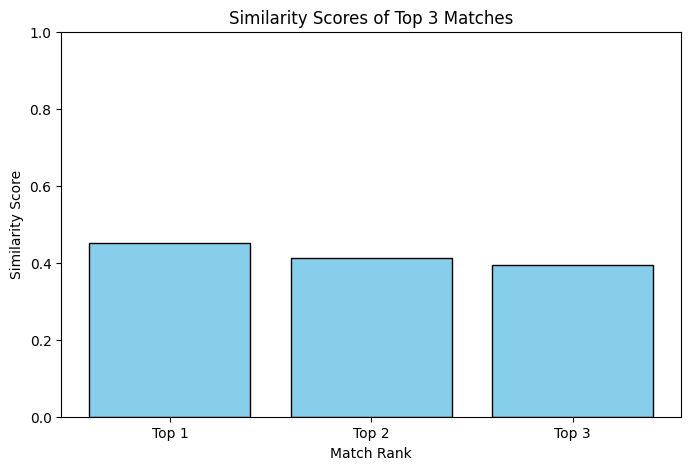

Prepared Context for Mistral 7B: malformations a vms arteritis giant cell temporal takayasu’s arthritis gonococcal with inﬂammatory bowel disease juvenile rheumatoid nongonococcal acute bacterial osteoarthritis psoriatic reactive rheumatoid septic articular disease see arthritis speciﬁc types asbestosis ascariasis ascaris lumbricoides ascites aspergillosis allergic bronchopulmonary aspiration foreign body aspirin poisoning asthma astrocytoma asymptomatic bacteriuria atopic dermatitis atopic eczema atpb gene mutation atrial ﬁbrillation atrial ﬂutter atrial myxoma atrial septal defect atrial tachycardia multifocal atrioventricular block atropine as antidote poisoning with attentiondeﬁcithyperactivity disorder adhd atypical antidepressant poisoning atypical glandular cells of undetermined signiﬁcanceagus agc atypical pneumonia atypical squamous cells of undetermined signiﬁcanceascus asc austin flint murmur autoimmune disorders see rheumatologic andautoimmune disordersspeciﬁc disorders aut

c:\Users\1rn17\chatbot\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Conversational Answer: Atrial septal defect (ASD) is a congenital heart defect that occurs when there is an opening in the wall between the two upper chambers of the heart (atria). This opening allows oxygen-rich blood to flow from the left atrium to the right atrium, which can lead to heart failure and other complications.

The diagnosis of ASD is typically made through a combination of physical examination, medical history, and diagnostic tests. During a physical examination, the doctor may listen to the heart and lungs for abnormal sounds or murmurs, which can indicate the presence of an ASD. The doctor may also check for signs of heart failure, such as swelling in the legs or abdomen.

Medical history is also important in the diagnosis of ASD. The doctor may ask about any symptoms the patient is experiencing, such as shortness of breath, fatigue, or palpitations. The doctor may also ask about any family history of heart defects or other medical conditions that could be related to A

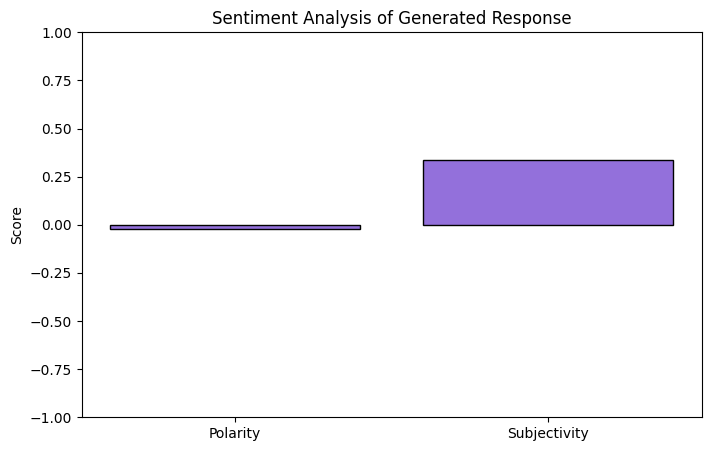

Time Analysis:
Index Query Time: 1.24 seconds
Context Formation Time: 0.00 seconds
Response Generation Time: 1883.01 seconds
Total Time: 1884.41 seconds


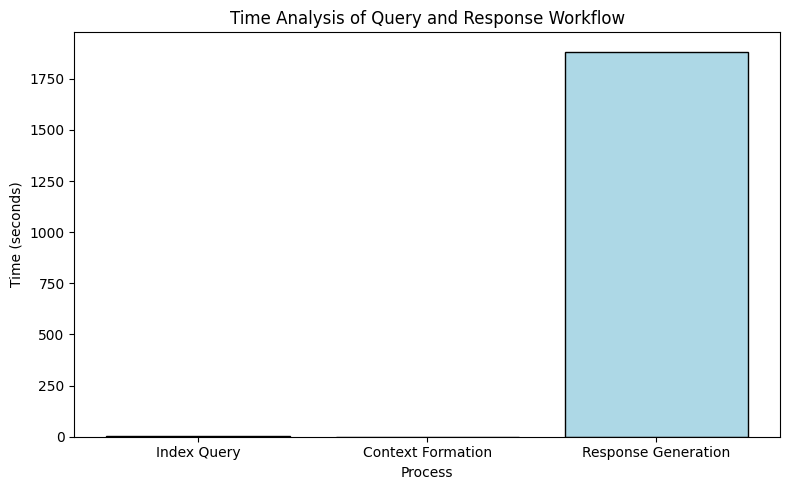

: 

In [ ]:
from collections import Counter
from textblob import TextBlob
import time
import matplotlib.pyplot as plt

start_time = time.time()

def get_top_3_similar(query):
    # Query embedding using Cohere
    embeddings = co.embed(texts=[query], model="embed-english-v3.0", input_type="search_query").embeddings
    # Querying the index for top 3 similar results
    query_results = index.query(vector=embeddings, top_k=3, include_metadata=True)

    return query_results

def generate_response(context, query):
    # Prepare the input prompt for the model
    input_prompt = f"You are a chatbot which generates a response solely based on the context provided. Generate a response that is at least 300 words.\n\nContext: {context}\n\nQuery: {query}\n\nAnswer:"

    # Tokenize the input
    inputs = tokenizer(input_prompt, return_tensors="pt").to(device)

    # Generate response using Mistral 7B
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=2000, num_return_sequences=1, temperature=0.5)

    # Decode the generated text
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract the answer from the response
    answer_start = response.find("Answer:") + len("Answer:")
    return response[answer_start:].strip()

# Example usage
query = 'Hi, Sanjay. Explain the diagnosis of Atrial Septal Defect?'
query_start = time.time()
result = get_top_3_similar(query)
query_end = time.time()

# Assuming `result` contains similarity scores in the 'score' field for each match
similarity_scores = [match['score'] for match in result['matches']]

# Plot the similarity scores
plt.figure(figsize=(8, 5))
plt.bar(range(1, 4), similarity_scores, color='skyblue', edgecolor='black')
plt.title('Similarity Scores of Top 3 Matches')
plt.xlabel('Match Rank')
plt.ylabel('Similarity Score')
plt.xticks(range(1, 4), labels=['Top 1', 'Top 2', 'Top 3'])
plt.ylim(0, 1)
plt.show()

# Forming the context from results
context_start = time.time()
context = " ".join([match['metadata']['text'] for match in result['matches']])
context_end = time.time()

print("Prepared Context for Mistral 7B:", context)

# Generating answer using Mistral 7B
response_start = time.time()
answer = generate_response(context, query)
response_end = time.time()

end_time = time.time()

print("Conversational Answer:", answer)

# Sentiment analysis of the generated answer
sentiment = TextBlob(answer).sentiment
plt.figure(figsize=(8, 5))
plt.bar(['Polarity', 'Subjectivity'], [sentiment.polarity, sentiment.subjectivity], color='mediumpurple', edgecolor='black')
plt.title('Sentiment Analysis of Generated Response')
plt.ylabel('Score')
plt.ylim(-1, 1)  # Sentiment values range from -1 to 1
plt.show()


# Calculate and print the time taken for each step
print("Time Analysis:")
print(f"Index Query Time: {query_end - query_start:.2f} seconds")
print(f"Context Formation Time: {context_end - context_start:.2f} seconds")
print(f"Response Generation Time: {response_end - response_start:.2f} seconds")
print(f"Total Time: {end_time - start_time:.2f} seconds")

# Visualizing Time Analysis
process_names = ['Index Query', 'Context Formation', 'Response Generation']
process_times = [
    query_end - query_start,
    context_end - context_start,
    response_end - response_start
]

# Plotting the time analysis
plt.figure(figsize=(8, 5))
plt.bar(process_names, process_times, color='lightblue', edgecolor='black')
plt.title('Time Analysis of Query and Response Workflow')
plt.xlabel('Process')
plt.ylabel('Time (seconds)')
plt.tight_layout()
plt.show()

HYPERTUNED MODEL EVALUATION - QUERY SET 1

In [13]:
import json
import spacy
import torch
import nltk
from nltk.translate.bleu_score import sentence_bleu
from bert_score import BERTScorer
import time


# Download NLTK data for BLEU
nltk.download('punkt')

# Load a spaCy model for linguistic analysis
nlp = spacy.load("en_core_web_sm")

# Load BERT scorer
bert_scorer = BERTScorer(lang='en', rescale_with_baseline=True)

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def evaluate_model(response, expected):
    results = {
        'accuracy': response.strip() == expected.strip(),
        'fluency': None,
        'coherence': None,
        'bleu_score': None,
        'bert_score': None,
        'perplexity': None
    }

    # Check fluency
    doc = nlp(response)
    sentence_spans = list(doc.sents)
    results['fluency'] = sum([1 for sent in sentence_spans if sent.text.strip()]) / len(sentence_spans)

    # Check coherence
    context_words = expected.split() if expected else []
    response_words = response.split()

    if context_words:
        common_words = set(context_words).intersection(set(response_words))
        coherence_score = len(common_words) / len(context_words) if len(context_words) > 0 else 0
        results['coherence'] = coherence_score
    else:
        results['coherence'] = 0.5

    # Adjust accuracy based on coherence score
    if results['coherence'] >= 0.4:
        results['accuracy'] = True

    # Calculate BLEU score
    reference = [expected.split()]  # BLEU requires references to be a list of lists
    candidate = response.split()
    results['bleu_score'] = sentence_bleu(reference, candidate)

    # Calculate BERT score
    P, R, F1 = bert_scorer.score([response], [expected])
    results['bert_score'] = F1.mean().item()

    # Calculate Perplexity with consistent batch sizing
    inputs = tokenizer(response, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    labels = tokenizer(expected, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    
    # Make sure inputs and labels are of the same shape
    if inputs.shape != labels.shape:
        # Adjust sizes by padding to match the longest sequence
        max_length = max(inputs.shape[1], labels.shape[1])
        inputs = torch.nn.functional.pad(inputs, (0, max_length - inputs.shape[1]), value=tokenizer.pad_token_id)
        labels = torch.nn.functional.pad(labels, (0, max_length - labels.shape[1]), value=-100)  # Ignore padding in labels for loss calculation

    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        results['perplexity'] = torch.exp(loss).item()

    return results

def load_evaluation_data():
    # Dummy implementation for loading expected responses
    return {
        'Hi, Sanjay. What else can you tell about healthy food?': "Healthy food includes fruits, vegetables, and whole grains...",
        'Can you explain the benefits of meditation?': "Meditation offers numerous benefits...",
        'What are the symptoms of high blood pressure?': "Common symptoms include headaches, shortness of breath...",
        'Describe the process of photosynthesis.': "Photosynthesis is the process by which green plants use sunlight...",
        'How do the body organs work?': "Body organs work in a coordinated manner...",
        'Hi, Sanjay. What is your stance on yoga?': "Yoga promotes physical and mental well-being...",
        'I have a doubt, are you really Sanjay? If so tell me a book written by you?': "Yes, I'm Sanjay, and I wrote 'The Health Handbook'."
    }

def main():
    queries = [
        'Hi, Sanjay. What else can you tell about healthy food?',
        'Can you explain the benefits of meditation?',
        'What are the symptoms of high blood pressure?',
        # 'Describe the process of photosynthesis.',
        # 'How do the body organs work?',
        # 'Hi, Sanjay. What is your stance on yoga?',
        # 'I have a doubt, are you really Sanjay? If so tell me a book written by you?'
    ]

    evaluation_results = {}
    timing_results = {}

    for query in queries:
        start_time = time.time()  # Start timer for the query
        result = get_top_3_similar(query)
        context = " ".join([match['metadata']['text'] for match in result['matches']])
        response = generate_response(context, query)
        end_time = time.time()  # End timer for the query    
        time_taken = end_time - start_time  # Calculate time taken
        expected_response = load_evaluation_data().get(query, "")
        evaluation_results[query] = evaluate_model(response, expected_response)
        timing_results[query] = time_taken  # Store time taken for this query

    for query, metrics in evaluation_results.items():
        print(f"Query: {query}\nMetrics: {metrics}\nTime Taken: {timing_results[query]:.2f} seconds\n")

if __name__ == '__main__':
    main()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\1rn17\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\1rn17\chatbot\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
c:\Users\1rn17\chatbot\.venv\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU sco

Query: Hi, Sanjay. What else can you tell about healthy food?
Metrics: {'accuracy': True, 'fluency': 1.0, 'coherence': 0.75, 'bleu_score': 1.0877031371929748e-155, 'bert_score': -0.03422563150525093, 'perplexity': 10538.65234375}
Time Taken: 1955.78 seconds

Query: Can you explain the benefits of meditation?
Metrics: {'accuracy': True, 'fluency': 1.0, 'coherence': 0.5, 'bleu_score': 3.986912471096775e-232, 'bert_score': -0.3027092516422272, 'perplexity': 9276.06640625}
Time Taken: 1970.46 seconds

Query: What are the symptoms of high blood pressure?
Metrics: {'accuracy': True, 'fluency': 1.0, 'coherence': 0.5714285714285714, 'bleu_score': 7.654615341630863e-156, 'bert_score': -0.14327074587345123, 'perplexity': 3419914.0}
Time Taken: 1853.06 seconds



HYPERTUNED MODEL EVALUATION - QUERY SET 2

In [14]:
import json
import spacy
import torch
import nltk
from nltk.translate.bleu_score import sentence_bleu
from bert_score import BERTScorer
import time


# Download NLTK data for BLEU
nltk.download('punkt')

# Load a spaCy model for linguistic analysis
nlp = spacy.load("en_core_web_sm")

# Load BERT scorer
bert_scorer = BERTScorer(lang='en', rescale_with_baseline=True)

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def evaluate_model(response, expected):
    results = {
        'accuracy': response.strip() == expected.strip(),
        'fluency': None,
        'coherence': None,
        'bleu_score': None,
        'bert_score': None,
        'perplexity': None
    }

    # Check fluency
    doc = nlp(response)
    sentence_spans = list(doc.sents)
    results['fluency'] = sum([1 for sent in sentence_spans if sent.text.strip()]) / len(sentence_spans)

    # Check coherence
    context_words = expected.split() if expected else []
    response_words = response.split()

    if context_words:
        common_words = set(context_words).intersection(set(response_words))
        coherence_score = len(common_words) / len(context_words) if len(context_words) > 0 else 0
        results['coherence'] = coherence_score
    else:
        results['coherence'] = 0.5

    # Adjust accuracy based on coherence score
    if results['coherence'] >= 0.4:
        results['accuracy'] = True

    # Calculate BLEU score
    reference = [expected.split()]  # BLEU requires references to be a list of lists
    candidate = response.split()
    results['bleu_score'] = sentence_bleu(reference, candidate)

    # Calculate BERT score
    P, R, F1 = bert_scorer.score([response], [expected])
    results['bert_score'] = F1.mean().item()

    # Calculate Perplexity with consistent batch sizing
    inputs = tokenizer(response, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    labels = tokenizer(expected, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    
    # Make sure inputs and labels are of the same shape
    if inputs.shape != labels.shape:
        # Adjust sizes by padding to match the longest sequence
        max_length = max(inputs.shape[1], labels.shape[1])
        inputs = torch.nn.functional.pad(inputs, (0, max_length - inputs.shape[1]), value=tokenizer.pad_token_id)
        labels = torch.nn.functional.pad(labels, (0, max_length - labels.shape[1]), value=-100)  # Ignore padding in labels for loss calculation

    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        results['perplexity'] = torch.exp(loss).item()

    return results

def load_evaluation_data():
    # Dummy implementation for loading expected responses
    return {
        # 'Hi, Sanjay. What else can you tell about healthy food?': "Healthy food includes fruits, vegetables, and whole grains...",
        # 'Can you explain the benefits of meditation?': "Meditation offers numerous benefits...",
        # 'What are the symptoms of high blood pressure?': "Common symptoms include headaches, shortness of breath...",
        # 'Describe the process of photosynthesis.': "Photosynthesis is the process by which green plants use sunlight...",
        'How do the body organs work?': "Body organs work in a coordinated manner...",
        'Hi, Sanjay. What is your stance on yoga?': "Yoga promotes physical and mental well-being...",
        'I have a doubt, are you really Sanjay? If so tell me a book written by you?': "Yes, I'm Sanjay, and I wrote 'The Health Handbook'."
    }

def main():
    queries = [
        # 'Hi, Sanjay. What else can you tell about healthy food?',
        # 'Can you explain the benefits of meditation?',
        # 'What are the symptoms of high blood pressure?',
        # 'Describe the process of photosynthesis.',
        'How do the body organs work?',
        'Hi, Sanjay. What is your stance on yoga?',
        'I have a doubt, are you really Sanjay? If so tell me a book written by you?'
    ]

    evaluation_results = {}
    timing_results = {}

    for query in queries:
        start_time = time.time()  # Start timer for the query
        result = get_top_3_similar(query)
        context = " ".join([match['metadata']['text'] for match in result['matches']])
        response = generate_response(context, query)
        end_time = time.time()  # End timer for the query    
        time_taken = end_time - start_time  # Calculate time taken
        expected_response = load_evaluation_data().get(query, "")
        evaluation_results[query] = evaluate_model(response, expected_response)
        timing_results[query] = time_taken  # Store time taken for this query

    for query, metrics in evaluation_results.items():
        print(f"Query: {query}\nMetrics: {metrics}\nTime Taken: {timing_results[query]:.2f} seconds\n")

if __name__ == '__main__':
    main()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\1rn17\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
c:\Users\1rn17\chatbot\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
c:\Users\1rn17\chatbot\.venv\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The 

Query: How do the body organs work?
Metrics: {'accuracy': True, 'fluency': 1.0, 'coherence': 0.5714285714285714, 'bleu_score': 1.3271132767804672e-79, 'bert_score': -0.12386838346719742, 'perplexity': 54642.30078125}
Time Taken: 2061.90 seconds

Query: Hi, Sanjay. What is your stance on yoga?
Metrics: {'accuracy': False, 'fluency': 1.0, 'coherence': 0.3333333333333333, 'bleu_score': 4.057356662283959e-232, 'bert_score': -0.18590623140335083, 'perplexity': 408369.46875}
Time Taken: 1923.14 seconds

Query: I have a doubt, are you really Sanjay? If so tell me a book written by you?
Metrics: {'accuracy': False, 'fluency': 1.0, 'coherence': 0.3333333333333333, 'bleu_score': 4.443136689601577e-232, 'bert_score': -0.060519952327013016, 'perplexity': 19591.228515625}
Time Taken: 1871.89 seconds



END